# BEST MODEL YET

In [2]:
import pandas as pd
import numpy as np
import chess
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import xgboost as xgb


In [3]:
# Load the dataset
data_path = r"C:\Users\hiddensardar\Downloads\ches.csv"
df = pd.read_csv(data_path)

# Check the first few rows of the dataset
print(df.head())



   Unnamed: 0                 White                Black Result  \
0           0  Donchenko, Alexander  Goltseva, Ekaterina    1-0   
1           1  Donchenko, Alexander    Semenenko, Dmytry    1-0   
2           2  Donchenko, Alexander       Ragger, Markus    1-0   
3           3  Donchenko, Alexander      Sjugirov, Sanan    1-0   
4           4  Donchenko, Alexander     Yurtseven, Melih    1-0   

                                          WhiteMoves  \
0  ['e4', 'Nf3', 'Nc3', 'exd5', 'Bc4', 'bxc3', 'O...   
1  ['e4', 'e5', 'd4', 'c4', 'exd6', 'Nc3', 'h3', ...   
2  ['d4', 'c4', 'Nc3', 'Nf3', 'cxd5', 'e4', 'bxc3...   
3  ['e4', 'Nf3', 'Bb5', 'O-O', 'c3', 'Re1', 'd4',...   
4  ['e4', 'Nf3', 'Bb5', 'Ba4', 'c3', 'd4', 'O-O',...   

                                          BlackMoves  \
0  ['c5', 'Nf6', 'd5', 'Nxd5', 'Nxc3', 'e6', 'Be7...   
1  ['Nf6', 'Nd5', 'd6', 'Nb6', 'cxd6', 'g6', 'Bg7...   
2  ['Nf6', 'g6', 'd5', 'Bg7', 'Nxd5', 'Nxc3', 'c5...   
3  ['c5', 'Nc6', 'g6', 'Bg7', 'Nf6',

In [6]:
def time_to_seconds(time_str):
    h, m, s = map(int, time_str.split(':'))
    return h * 3600 + m * 60 + s

# Apply the conversion for both white and black times
df['WhiteTimeLeft'] = df['WhiteTimes'].apply(lambda times: [time_to_seconds(t) for t in eval(times)])
df['BlackTimeLeft'] = df['BlackTimes'].apply(lambda times: [time_to_seconds(t) for t in eval(times)])



In [7]:
def compute_time_spent(time_list):
    return [time_list[i] - time_list[i+1] for i in range(len(time_list) - 1)]

df['WhiteTimeSpent'] = df['WhiteTimeLeft'].apply(compute_time_spent)
df['BlackTimeSpent'] = df['BlackTimeLeft'].apply(compute_time_spent)


In [8]:
def game_phase(move_number):
    if move_number <= 15:
        return 'Opening'
    elif move_number <= 40:
        return 'Middlegame'
    else:
        return 'Endgame'

df['GamePhase'] = df.apply(lambda row: game_phase(len(eval(row['WhiteMoves'])) + len(eval(row['BlackMoves']))), axis=1)


In [9]:
def extract_piece_moves(moves):
    board = chess.Board()
    piece_moves = []
    for move in eval(moves):
        try:
            uci_move = board.parse_san(move).uci()
            piece = board.piece_at(chess.SQUARE_NAMES.index(uci_move[:2])).symbol()
            piece_moves.append(piece)
            board.push_san(move)
        except:
            continue
    return piece_moves

df['WhitePieceMoves'] = df['WhiteMoves'].apply(extract_piece_moves)
df['BlackPieceMoves'] = df['BlackMoves'].apply(extract_piece_moves)


In [10]:
def material_count(board):
    piece_values = {'P': 1, 'N': 3, 'B': 3, 'R': 5, 'Q': 9, 'K': 0,
                    'p': -1, 'n': -3, 'b': -3, 'r': -5, 'q': -9, 'k': 0}
    material = sum([piece_values.get(piece.symbol(), 0) for piece in board.piece_map().values()])
    return material

def material_advantage(moves):
    board = chess.Board()
    material_advantage_list = []
    for move in eval(moves):
        material_advantage_list.append(material_count(board))
        try:
            board.push_san(move)
        except:
            continue
    return material_advantage_list

df['WhiteMaterialAdvantage'] = df['WhiteMoves'].apply(material_advantage)
df['BlackMaterialAdvantage'] = df['BlackMoves'].apply(material_advantage)


In [11]:
def board_to_features(board):
    piece_mapping = {
        'P': 1, 'N': 2, 'B': 3, 'R': 4, 'Q': 5, 'K': 6,
        'p': -1, 'n': -2, 'b': -3, 'r': -4, 'q': -5, 'k': -6,
        '.': 0
    }
    features = []
    for row in range(8):
        for col in range(8):
            piece = board.piece_at(chess.square(col, row))
            features.append(piece_mapping[piece.symbol()] if piece else 0)
    return np.array(features)


In [12]:
X = []  # Features
y = []  # Labels (target moves)

for index, row in df.iterrows():
    board = chess.Board()
    moves = eval(row['WhiteMoves']) if row['White'] == 'Donchenko, Alexander' else eval(row['BlackMoves'])

    for i, move in enumerate(moves):
        try:
            uci_move = board.parse_san(move).uci()
        except:
            continue

        # Extract board features
        board_features = board_to_features(board)
        
        # Extract additional features: time, material advantage, game phase
        white_time_spent = row['WhiteTimeSpent'][i] if i < len(row['WhiteTimeSpent']) else 0
        black_time_spent = row['BlackTimeSpent'][i] if i < len(row['BlackTimeSpent']) else 0
        white_material = row['WhiteMaterialAdvantage'][i] if i < len(row['WhiteMaterialAdvantage']) else 0
        black_material = row['BlackMaterialAdvantage'][i] if i < len(row['BlackMaterialAdvantage']) else 0
        game_phase = 1 if row['GamePhase'] == 'Opening' else (2 if row['GamePhase'] == 'Middlegame' else 3)
        
        # Combine all features into one array
        features = np.hstack([board_features, white_time_spent, black_time_spent, white_material, black_material, game_phase])
        X.append(features)
        y.append(uci_move)  # Target label
        
        # Make the move on the board
        board.push_san(move)

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [14]:
# Combine train and test labels to fit the encoder on all possible UCI moves
le = LabelEncoder()
le.fit(np.concatenate([y_train, y_test]))

# Transform labels for training and testing
y_train_encoded = le.transform(y_train)
y_test_encoded = le.transform(y_test)

# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train_encoded)
dtest = xgb.DMatrix(X_test, label=y_test_encoded)

# Set XGBoost parameters
params = {
    'objective': 'multi:softmax',  # Multi-class classification
    'num_class': len(le.classes_), # Number of move classes
    'eval_metric': 'mlogloss',     # Log loss for evaluation
    'max_depth': 20,                # Maximum tree depth
    'eta': 0.1,                    # Learning rate
    'subsample': 0.8,              # Row subsample ratio
    'colsample_bytree': 0.8,       # Column subsample ratio
    'seed': 42                     # Seed for reproducibility
}

# Train the model
num_rounds = 500
bst = xgb.train(params, dtrain, num_boost_round=num_rounds)

# Predict on the test set
y_pred = bst.predict(dtest)


In [15]:
# Evaluate the model's accuracy
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"XGBoost Model Accuracy: {accuracy * 100:.2f}%")

XGBoost Model Accuracy: 27.33%


In [16]:
# Save the trained model
model_save_path = r"D:\CAPABLANCA\Models\xgboost_chess_model_27.bst"
bst.save_model(model_save_path)
print(f"XGBoost model saved to {model_save_path}")


C:\Users\hiddensardar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\core.py:158: UserWarning: [12:32:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


XGBoost model saved to D:\CAPABLANCA\Models\xgboost_chess_model_27.bst


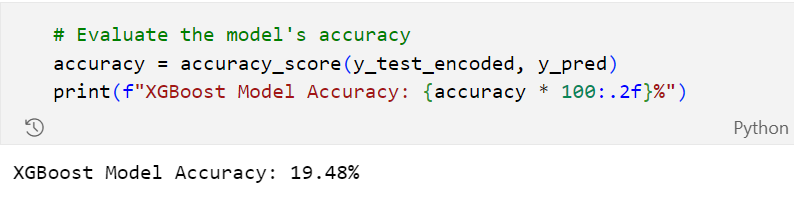

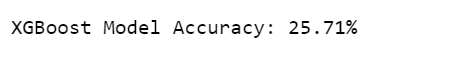

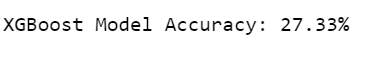

# Additional tries

Still this accuracy is good we will increase this after that now lets move forward with different modifications

In [9]:
import chess.engine

# Provide the path to your Stockfish engine
stockfish_path = r"C:\Users\hiddensardar\Downloads\stockfish-windows-x86-64-avx2\stockfish\stockfish-windows-x86-64-avx2.exe" 

# Initialize the Stockfish engine
engine = chess.engine.SimpleEngine.popen_uci(stockfish_path)


In [ ]:
from sklearn.preprocessing import StandardScaler
import chess.engine


def evaluate_move_difficulty(board, move):
    try:
        # Convert move to UCI format
        uci_move = board.parse_san(move).uci()
        # Evaluate board before the move
        info = engine.analyse(board, chess.engine.Limit(time=0.1))
        board_value_before = info["score"].relative.score()
        # Make the move
        board.push_san(move)
        # Evaluate board after the move
        info_after = engine.analyse(board, chess.engine.Limit(time=0.1))
        board_value_after = info_after["score"].relative.score()
        # Calculate difficulty as centipawn loss
        difficulty = abs(board_value_after - board_value_before)
    except:
        difficulty = 0
    return difficulty

# Apply the function to both white and black moves
df['WhiteMoveDifficulty'] = df['WhiteMoves'].apply(lambda moves: [evaluate_move_difficulty(chess.Board(), move) for move in eval(moves)])
df['BlackMoveDifficulty'] = df['BlackMoves'].apply(lambda moves: [evaluate_move_difficulty(chess.Board(), move) for move in eval(moves)])

# Scaling the time spent and difficulty features
scaler = StandardScaler()

# Features to scale
time_features = ['WhiteTimeSpent', 'BlackTimeSpent', 'WhiteMoveDifficulty', 'BlackMoveDifficulty']

for feature in time_features:
    # Flatten the lists and fit the scaler
    flat_list = [item for sublist in df[feature] for item in sublist]
    scaled_flat_list = scaler.fit_transform(np.array(flat_list).reshape(-1, 1)).flatten()
    
    # Split the scaled list back into the original shape
    scaled_split_list = [scaled_flat_list[i:i+len(df.iloc[index][feature])] for index, i in enumerate(range(0, len(scaled_flat_list), len(df.iloc[0][feature])))]
    
    df[feature + '_scaled'] = scaled_split_list


In [ ]:
# Adjusting XGBoost parameters
params = {
    'objective': 'multi:softmax',
    'num_class': len(le.classes_),
    'eval_metric': 'mlogloss',
    'max_depth': 15,          # Decrease depth to avoid overfitting
    'eta': 0.05,              # Reduce learning rate
    'subsample': 0.7,         # More aggressive subsampling
    'colsample_bytree': 0.7,  # Less columns used per tree
    'min_child_weight': 5,    # Add a minimum child weight to avoid overfitting
    'seed': 42
}

# Retrain the model with new parameters
num_rounds = 1000  # Increase the number of boosting rounds
bst = xgb.train(params, dtrain, num_boost_round=num_rounds)

# Predict on the test set
y_pred = bst.predict(dtest)


In [ ]:
# Implement cross-validation and early stopping
cv_results = xgb.cv(
    params, dtrain, num_boost_round=num_rounds, nfold=5,
    early_stopping_rounds=50, metrics="mlogloss", seed=42
)

# Train the model with the best number of boosting rounds
best_num_rounds = cv_results['test-mlogloss-mean'].idxmin()
bst = xgb.train(params, dtrain, num_boost_round=best_num_rounds)


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Predict on the test set
y_pred = bst.predict(dtest)
y_pred_labels = le.inverse_transform(y_pred.astype(int))

# Accuracy
accuracy = accuracy_score(y_test, y_pred_labels)
print(f'Updated Model Accuracy: {accuracy * 100:.2f}%')

# Confusion Matrix
print(confusion_matrix(y_test, y_pred_labels))


In [1]:
# Time model

In [4]:
def extract_time_features(board, move_number, cumulative_time):
    # Basic board features: Extract the board state as before
    feature_vector = extract_features(board)  # Reuse your existing feature extraction
    
    # Add additional time-related features
    game_phase = 1 if move_number <= 15 else (2 if move_number <= 40 else 3)  # Opening, Middlegame, Endgame
    material_advantage = sum([piece_value(piece) for piece in board.piece_map().values()])
    
    # Combine all features: board state, game phase, move number, and cumulative time
    time_features = np.array([move_number, cumulative_time, game_phase, material_advantage])
    
    full_feature_vector = np.hstack([feature_vector, time_features])  # Combine board features + time features
    return full_feature_vector

# Function to assign value to each piece (useful for material advantage)
def piece_value(piece):
    piece_values = {'P': 1, 'N': 3, 'B': 3, 'R': 5, 'Q': 9, 'K': 0,
                    'p': -1, 'n': -3, 'b': -3, 'r': -5, 'q': -9, 'k': 0}
    return piece_values.get(piece.symbol(), 0)


In [8]:
import pandas as pd
import chess
import numpy as np

# Load the dataset
data_path = r"C:\Users\hiddensardar\Downloads\ches.csv"
df = pd.read_csv(data_path)

# Function to convert time from 'HH:MM:SS' to seconds
def time_to_seconds(time_str):
    h, m, s = map(int, time_str.split(':'))
    return h * 3600 + m * 60 + s

# Function to calculate time spent on each move
def compute_time_spent(times_list):
    times_in_seconds = [time_to_seconds(t) for t in eval(times_list)]
    return [times_in_seconds[i] - times_in_seconds[i + 1] for i in range(len(times_in_seconds) - 1)]

# Initialize lists for features and target (time spent)
X = []
y = []

# Loop over the dataset to extract features and time spent for each move
for index, row in df.iterrows():
    board = chess.Board()
    
    # Calculate time spent for White and Black moves
    white_time_spent = compute_time_spent(row['WhiteTimes'])
    black_time_spent = compute_time_spent(row['BlackTimes'])

    # Extract features and time for White moves
    for i, move in enumerate(eval(row['WhiteMoves'])):
        board.push_san(move)
        features = extract_time_features(board, i + 1, sum(white_time_spent[:i]))  # Cumulative time for White
        X.append(features)
        y.append(white_time_spent[i] if i < len(white_time_spent) else 0)  # Time spent for this move

    # Extract features and time for Black moves
    for i, move in enumerate(eval(row['BlackMoves'])):
        board.push_san(move)
        features = extract_time_features(board, i + 1, sum(black_time_spent[:i]))  # Cumulative time for Black
        X.append(features)
        y.append(black_time_spent[i] if i < len(black_time_spent) else 0)  # Time spent for this move

# Convert to numpy arrays for the model input
X = np.array(X)
y = np.array(y)


NameError: name 'extract_features' is not defined

In [6]:
# Check the columns in your dataset
print(df.columns)


Index(['Unnamed: 0', 'White', 'Black', 'Result', 'WhiteMoves', 'BlackMoves',
       'WhiteTimes', 'BlackTimes', 'TotalSeconds'],
      dtype='object')


SyntaxError: leading zeros in decimal integer literals are not permitted; use an 0o prefix for octal integers (1024126257.py, line 297)